In [1]:
import json
import requests
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

### Connect to local SQLite3 database
Create a new table `earthquakes` with columns:
| magnitude | latitude | longitude | depth |
| --------- | -------- | --------- | ----- |

In [2]:
connection = sqlite3.connect("results/data.db")
cursor = connection.cursor()
cursor.execute("DROP TABLE IF EXISTS earthquakes")
cursor.execute(
    "CREATE TABLE earthquakes(magnitude REAL, latitude REAL, longitude REAL, depth REAL)"
)

### Store data into database
Read data from USGS API and store each earthquake's features into the database.

In [3]:
# earthquakes = requests.get('https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson').json()["features"]
with open("data/earthquakes.json", "r") as f:
    earthquakes = json.load(f)["features"]

data = [(e["properties"]["mag"], *e["geometry"]["coordinates"]) for e in earthquakes]
cursor.executemany("INSERT INTO earthquakes VALUES(?, ?, ?, ?)", data)
connection.commit()

### Load data and Data Cleaning
Read `earthquakes` table from SQLite database into a Pandas DataFrame object.
Here, we also do some basic data cleaning by removing less significant earthquakes

In [4]:
# Fetch data from SQLite3 database into a DataFrame
df = pd.read_sql_query('SELECT * FROM earthquakes WHERE magnitude > 3', connection)
df.head()

,magnitude,latitude,longitude,depth
0,5.60,-176.2119,-27.8196,10.000
1,3.71,-68.8625,19.2645,56.000
2,3.90,-129.9249,44.3214,10.000
3,3.80,-170.4816,52.0086,43.119
4,4.50,155.2367,49.2503,67.294


### Data cleaning
1. We first need to check if any data is missing. In this dataset, all data is present, so no imputation needs to be done.
1. Some earthquakes have a insignificant magnitude. These are not felt (or felt very loosely) by humans, and so we can remove them. This was
done in the `SELECT` statement above

In [5]:
print("NA Values:")
df.isna().sum()

NA Values:


magnitude    0
latitude     0
longitude    0
depth        0
dtype: int64

### Exploratory Analysis
Understand underlying relationships between the data.

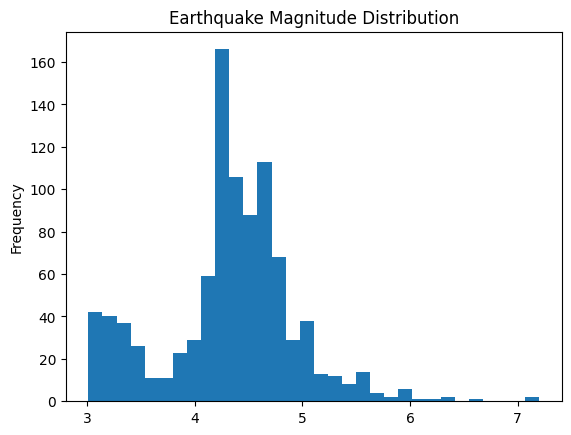

In [6]:
df["magnitude"].plot(kind='hist', bins=32)
plt.title('Earthquake Magnitude Distribution')
plt.savefig('results/magnitude_histogram.png')
plt.show()

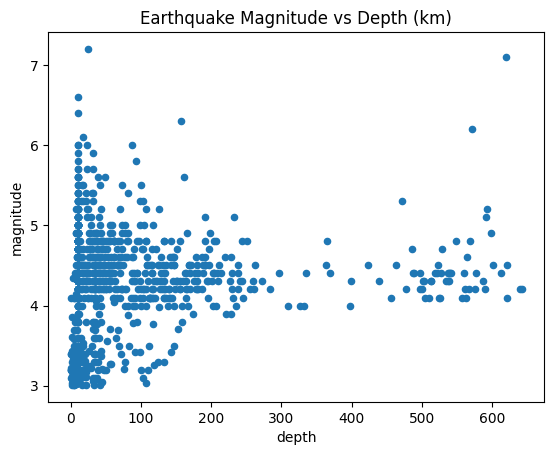

In [7]:
df.plot(x='depth', y='magnitude', kind='scatter')
plt.title('Earthquake Magnitude vs Depth (km)')
plt.savefig('results/magnitude_depth_scatter.png')
plt.show()

### Plot earthquakes on map
Using GeoPandas and Matplotlib, we can visualize the location of each earthquake on a 2D map.
What's interesting to note here, is that the earthquakes seem to line up precisely with the boundaries
of tectonic plates.

In [8]:
countries = gpd.read_file(geodatasets.get_path("naturalearth.land"))
tectonic_plates = gpd.read_file("tectonic/tectonic_plates.shp")

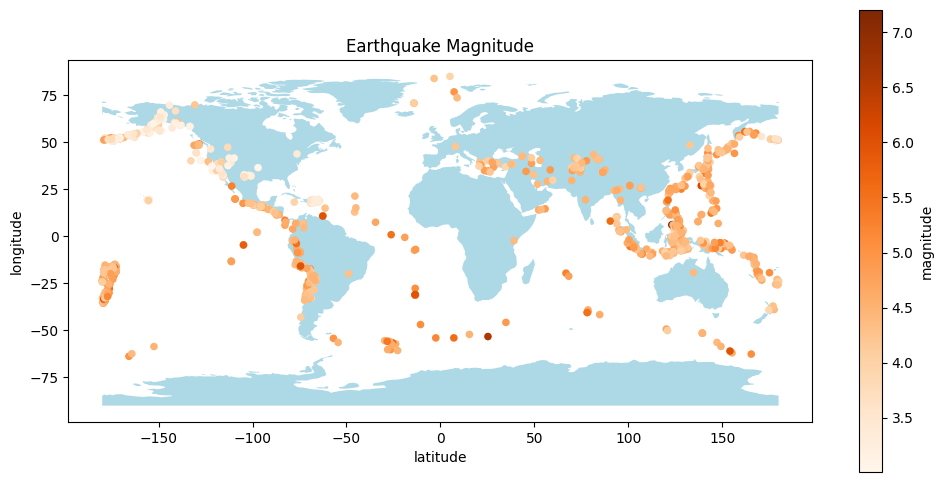

In [9]:
figure, ax = plt.subplots(figsize=(12, 6))
countries.plot(color="lightblue", ax=ax, zorder=1)
df.plot(x='latitude', y='longitude', c='magnitude', colormap='Oranges', kind='scatter', ax=ax, zorder=3)
plt.title('Earthquake Magnitude')
plt.savefig('results/magnitude_scatter.png')
plt.show()

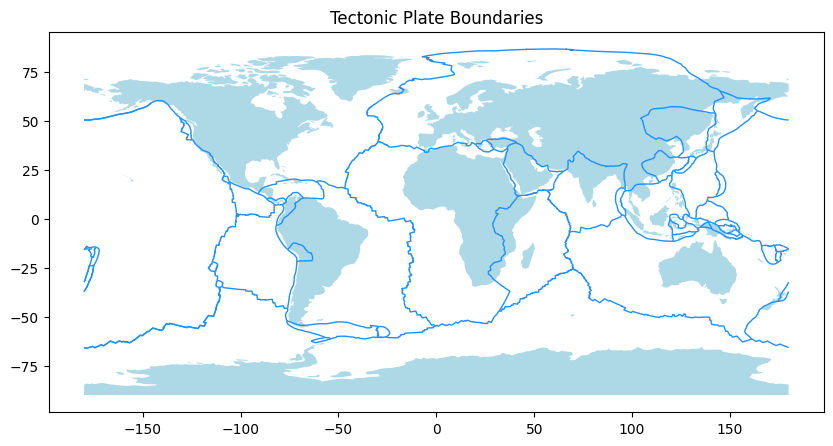

In [10]:
figure, ax = plt.subplots(figsize=(10, 6))
countries.plot(color="lightblue", ax=ax, zorder=1)
tectonic_plates.plot(color="dodgerblue", linewidth=1, ax=ax, zorder=2)
plt.title('Tectonic Plate Boundaries')
plt.savefig('results/tectonic_plates.png')
plt.show()

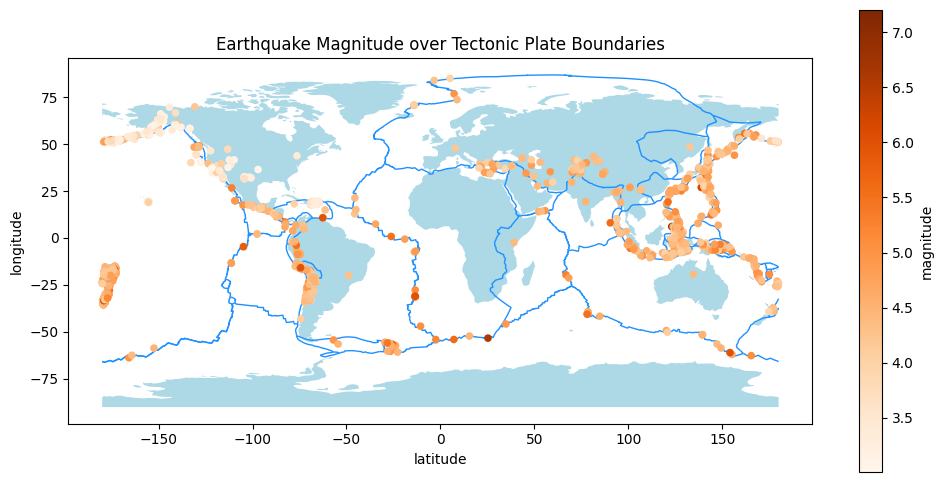

In [11]:
figure, ax = plt.subplots(figsize=(12, 6))
countries.plot(color="lightblue", ax=ax, zorder=1)
tectonic_plates.plot(color="dodgerblue", linewidth=1, ax=ax, zorder=2)
df.plot(x='latitude', y='longitude', c='magnitude', colormap='Oranges', kind='scatter', ax=ax, zorder=3)
plt.title('Earthquake Magnitude over Tectonic Plate Boundaries')
plt.savefig('results/tectonic_plates_magnitude_scatter.png')
plt.show()

### Predict magnitude of Earthquake using RandomForestRegressor
Here, we train a Random forest model to predict the magnitude of an earth quake given the other features.
We use a standard train test split of 75:25 to validate the model.

In [12]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

x_train = train.drop(columns=['magnitude'])
y_train = train['magnitude']

x_test = test.drop(columns=['magnitude'])
y_test = test['magnitude']

In [13]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=100)
rf.fit(x_train, y_train)

RandomForestRegressor(min_samples_leaf=100)

In [14]:
error = np.square((rf.predict(x_test) - y_test)).mean()
error

np.float64(0.19840402744430308)

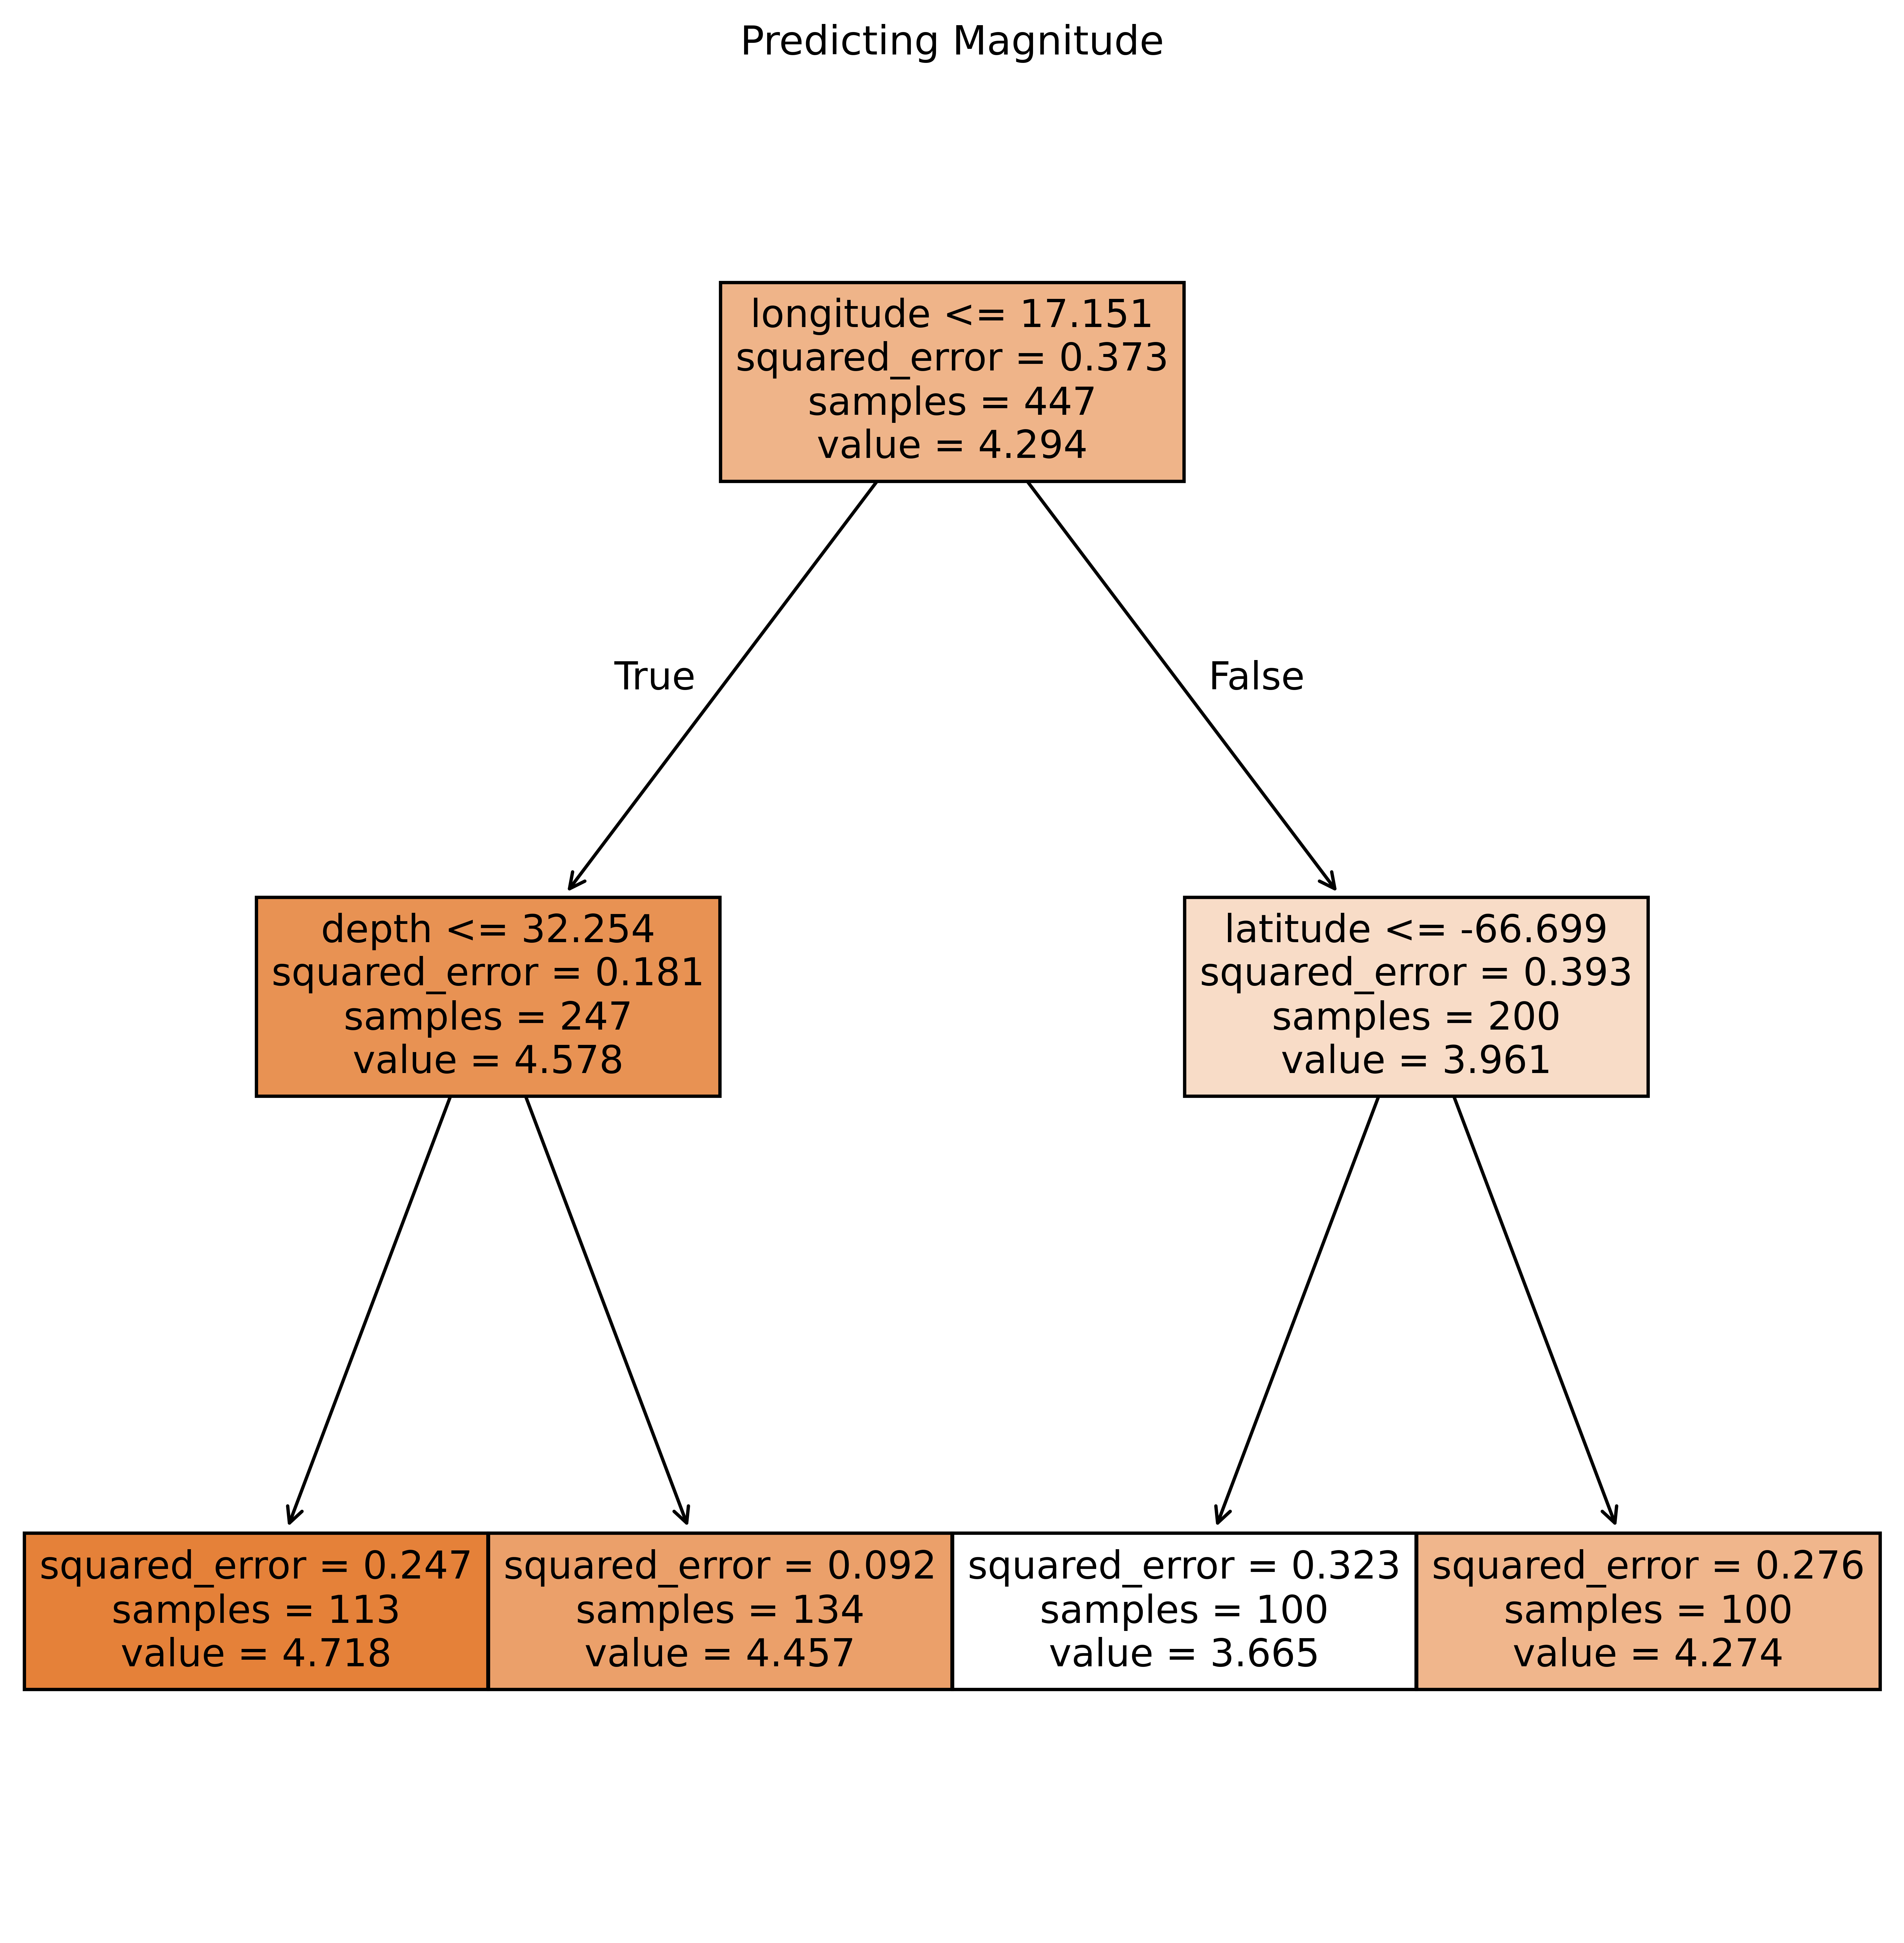

In [15]:
fig, axes = plt.subplots(figsize = (10, 10), dpi=800)
plot_tree(rf.estimators_[0], feature_names=x_train.columns, filled=True)
plt.title('Predicting Magnitude')
plt.savefig('results/rf_regressor.png')
plt.show()

### Calculate distances to closest plate boundary
Here, we show that most earthquakes lie close to a tectonic plate boundary. Specifically, 75% of earthquakes
are within 6.68 degrees of a plate boundary.

In [16]:
distances = []
for _, (_, lat, lon, _) in df.iterrows():
    point = Point(lat, lon)
    distances.append(np.min(tectonic_plates.distance(point)))

df = df.assign(distance_to_closest_plate_boundary=distances)
df.head()

,magnitude,latitude,longitude,depth,distance_to_closest_plate_boundary
0,5.60,-176.2119,-27.8196,10.000,0.410702
1,3.71,-68.8625,19.2645,56.000,0.324645
2,3.90,-129.9249,44.3214,10.000,0.048500
3,3.80,-170.4816,52.0086,43.119,0.617407
4,4.50,155.2367,49.2503,67.294,1.523767


In [17]:
df['distance_to_closest_plate_boundary'].describe()

count    952.000000
mean       2.139864
std        5.053048
min        0.000124
25%        0.348599
50%        0.808397
75%        1.745057
max       35.026602
Name: distance_to_closest_plate_boundary, dtype: float64

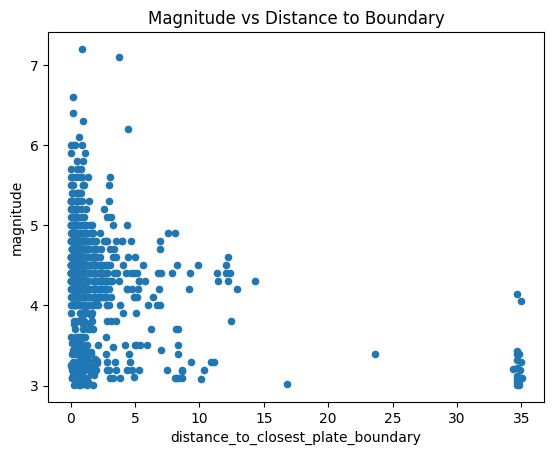

In [18]:
df.plot(x="distance_to_closest_plate_boundary", y="magnitude", kind="scatter")
plt.title('Magnitude vs Distance to Boundary')
plt.savefig('results/magnitude_vs_distance.png')
plt.show()

### Predicting using distance to boundary
Here, we compare the predictive power of a Random Forest model that also has access to the engineered 
feature of distance to closest tectonic plate boundary. This helps us see whether distance is actually significant here.

We use the same configuration for this model to avoid confounding.

In [19]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

x_train = train.drop(columns=['magnitude'])
y_train = train['magnitude']

x_test = test.drop(columns=['magnitude'])
y_test = test['magnitude']

In [20]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=100)
rf.fit(x_train, y_train)

RandomForestRegressor(min_samples_leaf=100)

In [21]:
error = np.square((rf.predict(x_test) - y_test)).mean()
error

np.float64(0.1951464511104683)

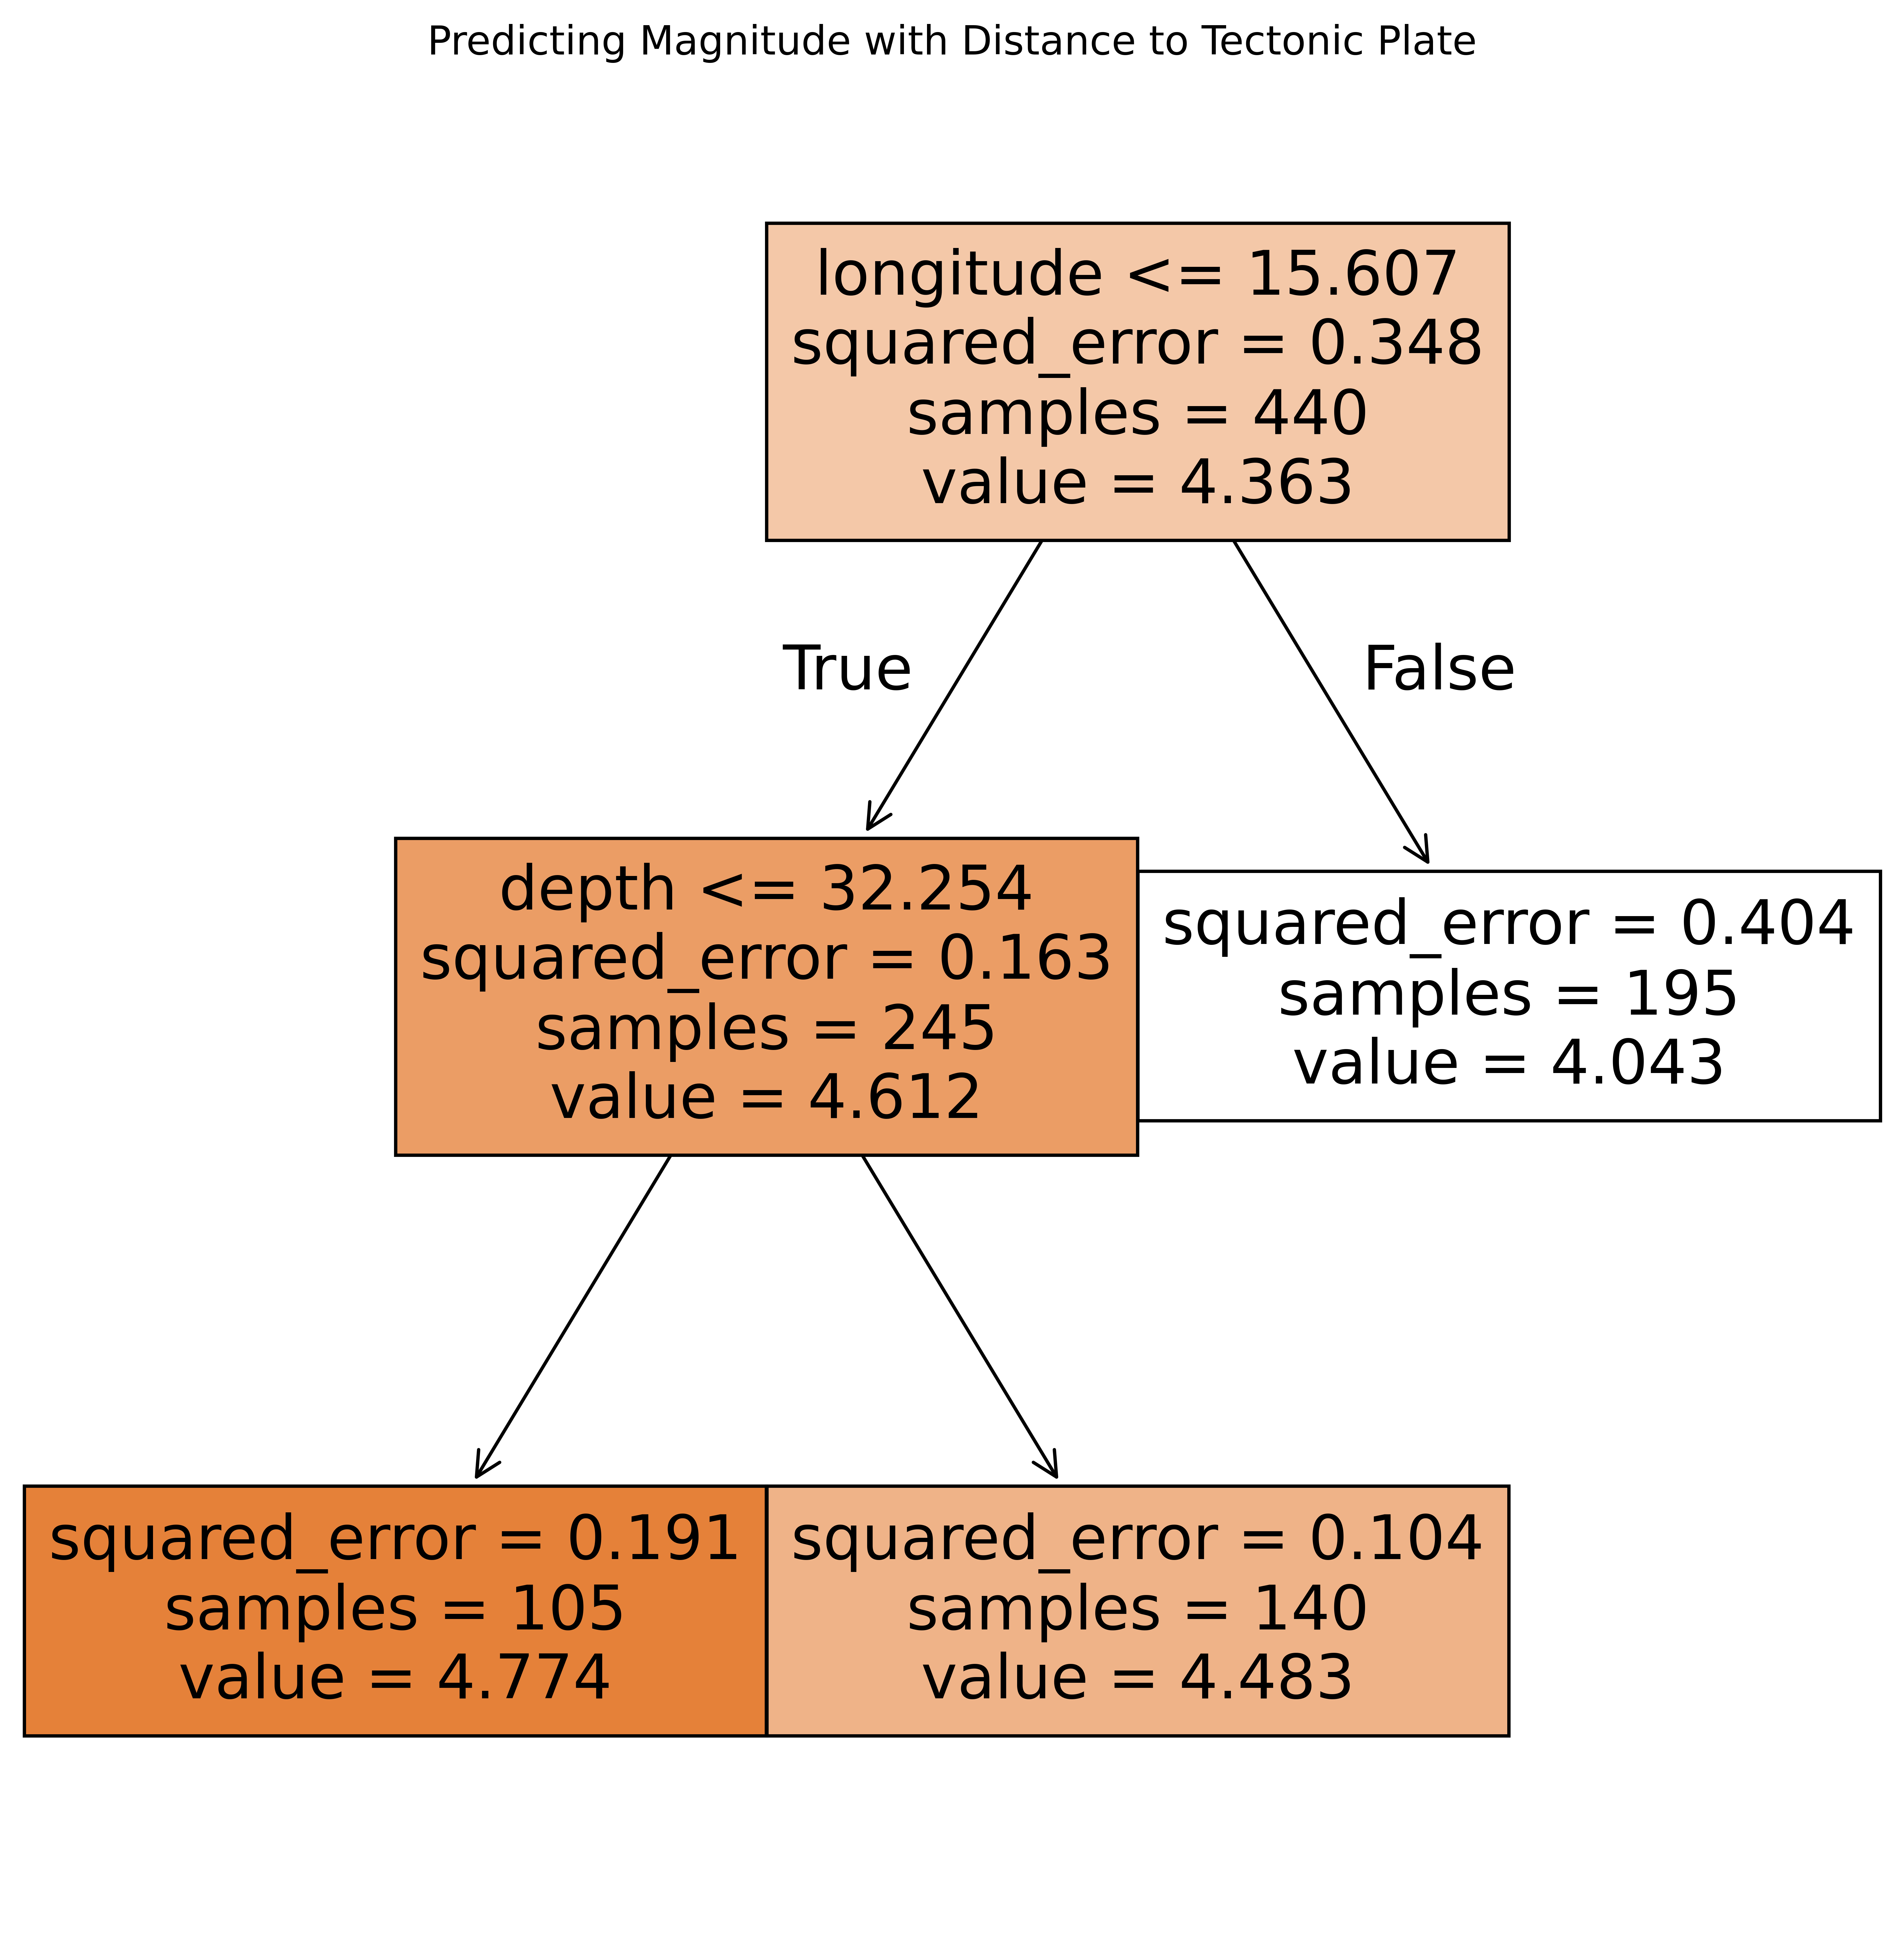

In [22]:
fig, axes = plt.subplots(figsize = (10, 10), dpi=800)
plot_tree(rf.estimators_[0], feature_names=x_train.columns, filled=True)
plt.title('Predicting Magnitude with Distance to Tectonic Plate')
plt.savefig('results/rf_regressor_with_distance.png')
plt.show()